In [44]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

config = {
    "months": ["2020-1", "2020-4", "2020-7", "2021-10"],
    "raw_folder": "data/raw",
    "intermediate_folder": "data/processed",
    "use_channels": ["swvl1"],  # more channels can be added later
    "input_days": 5,
    "predict_days": 3,
    "batch_size": 4,
    "epochs": 10
}

VAR_MAP = {
    "swvl1": "swvl1",
    "ro": "ro",
    "e": "e",
    "tp": "tp"
}

# check if precessed folder exists, if not create it
if not os.path.exists(config["intermediate_folder"]):
    raise FileNotFoundError(f"Intermediate folder {config['intermediate_folder']} does not exist. Please create it first.")

In [45]:
# ---------------- VISUALIZATION UTILS ----------------
def plot_variable_day(data, lat, lon, day_index, channel_index=0, title=None):
    """可视化单天单通道变量"""
    var_data = data[:, :, channel_index]
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = ax.pcolormesh(lon, lat, var_data, cmap='YlGnBu', shading='auto')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(title or f"Day {day_index}, Var {channel_index}")
    plt.colorbar(im, orientation='vertical', label=config["use_channels"][channel_index])
    plt.tight_layout()
    plt.show()

def plot_tensor_sample(x, y, lat, lon):
    """可视化一个样本的输入和输出"""
    # x: (input_days, C, H, W), y: (predict_days, 1, H, W)
    for t in range(x.shape[0]):
        plot_variable_day(np.transpose(x[t], (1,2,0))[...,0:1], lat, lon, 0, 0, f"Input day {t+1}")
    for t in range(y.shape[0]):
        plot_variable_day(np.transpose(y[t], (1,2,0)), lat, lon, 0, 0, f"Target day {t+1}")


In [51]:
# --- STEP 1: PROCESS & SAVE DAILY AVERAGED FILES ---
def process_month_to_daily_mean(month_str):
    input_path = os.path.join(config["raw_folder"], f"{month_str}.nc")
    output_path = os.path.join(config["intermediate_folder"], f"{month_str}.npy")
    ds = xr.open_dataset(input_path)
    var_stack = []

    for var in config["use_channels"]:
        var_data = ds[VAR_MAP[var]].values  # (time, lat, lon)
        total_hours = var_data.shape[0]
        days = total_hours // 24
        daily_data = var_data[:days * 24].reshape(days, 24, *var_data.shape[1:]).mean(axis=1)  # (days, lat, lon)
        daily_data = np.nan_to_num(daily_data, nan=0.0)
        var_stack.append(daily_data)

    daily_array = np.stack(var_stack, axis=-1)  # (days, lat, lon, channels)
    # daily_array = np.transpose(daily_array, (1, 2, 0, 3))  # to (lat, lon, days, channels)
    np.save(output_path, daily_array)
    print(f"Saved daily mean to {output_path} shape={daily_array.shape}")

for month in config["months"]:
    process_month_to_daily_mean(month)


Saved daily mean to data/processed/2020-1.npy shape=(31, 371, 701, 1)
Saved daily mean to data/processed/2020-4.npy shape=(30, 371, 701, 1)
Saved daily mean to data/processed/2020-7.npy shape=(31, 371, 701, 1)
Saved daily mean to data/processed/2021-10.npy shape=(31, 371, 701, 1)


In [52]:
# --- STEP 2: LOAD ALL MONTHLY FILES & CONCAT ---
def load_combined_data():
    monthly_arrays = []
    for month in config["months"]:
        arr = np.load(os.path.join(config["intermediate_folder"], f"{month}.npy"))
        monthly_arrays.append(arr)
    final_array = np.concatenate(monthly_arrays, axis=0)  # concat over day axis
    print(f"Final combined shape: {final_array.shape}")  # (lat, lon, total_days, channels)
    return final_array

data_array = load_combined_data()  # (T, H, W, C)

Final combined shape: (123, 371, 701, 1)


In [53]:
# --- STEP 3: LAT/LON ---
sample_nc = xr.open_dataset(os.path.join(config["raw_folder"], f"{config['months'][0]}.nc"))
lat = sample_nc['latitude'].values
lon = sample_nc['longitude'].values

In [54]:
# --- STEP 4: Transform to Tensor ---
def prepare_tensor_data(data):
    # (T, H, W, C) -> (T, C, H, W)
    return np.transpose(data, (0, 3, 1, 2))

tensor_data = prepare_tensor_data(data_array)
print(f"tensor data shape: {tensor_data.shape}")  # (T, C, H, W)


tensor data shape: (123, 1, 371, 701)


In [55]:
tensor_data[50, 0, :, :]

array([[0.39430237, 0.39723206, 0.39616394, ..., 0.        , 0.        ,
        0.        ],
       [0.39509583, 0.3979187 , 0.40072632, ..., 0.        , 0.        ,
        0.        ],
       [0.39839172, 0.4031372 , 0.40786743, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19502576, 0.27140936,
        0.28237724],
       [0.        , 0.        , 0.        , ..., 0.16074626, 0.16403897,
        0.21825282],
       [0.        , 0.        , 0.        , ..., 0.14854813, 0.14975612,
        0.16615169]], shape=(371, 701), dtype=float32)

Available samples: 116
Dataset split: train=81, val=23, test=12
Sample x shape: torch.Size([5, 1, 371, 701]), y shape: torch.Size([3, 1, 371, 701])


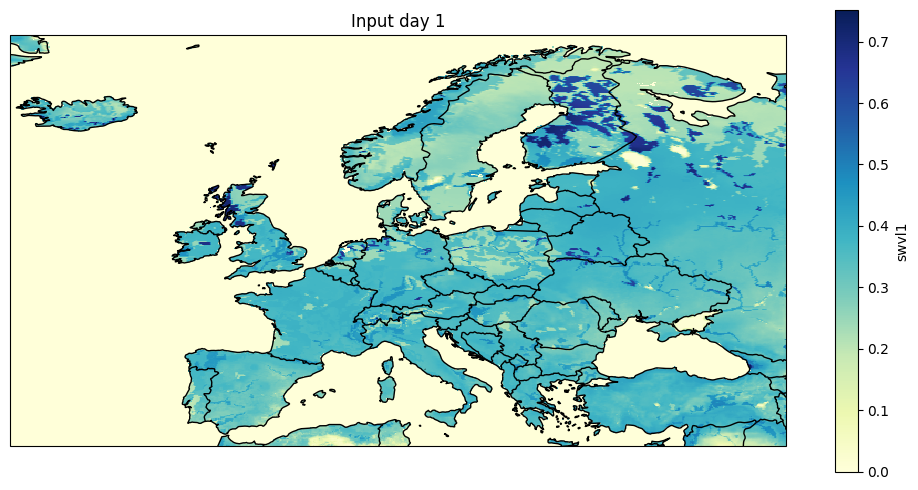

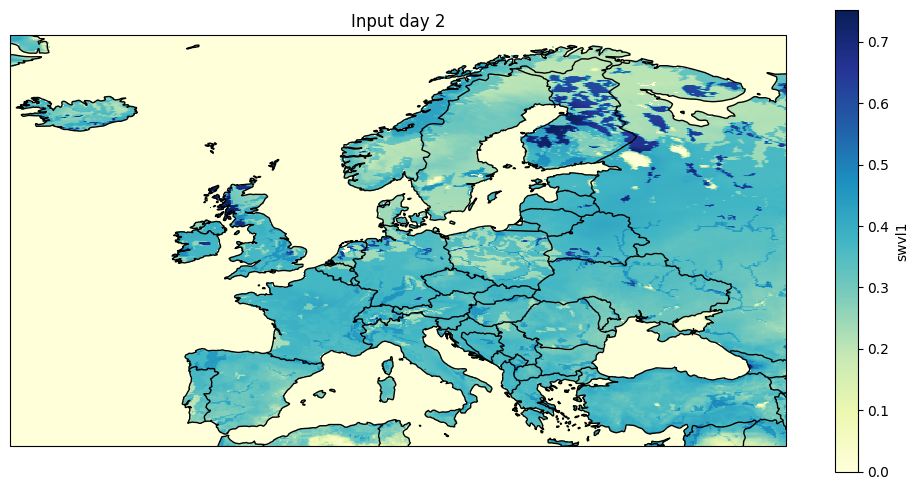

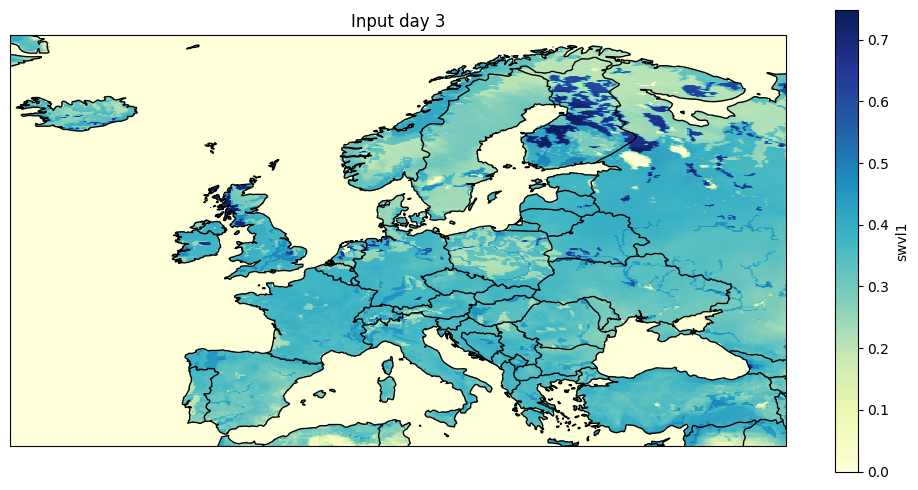

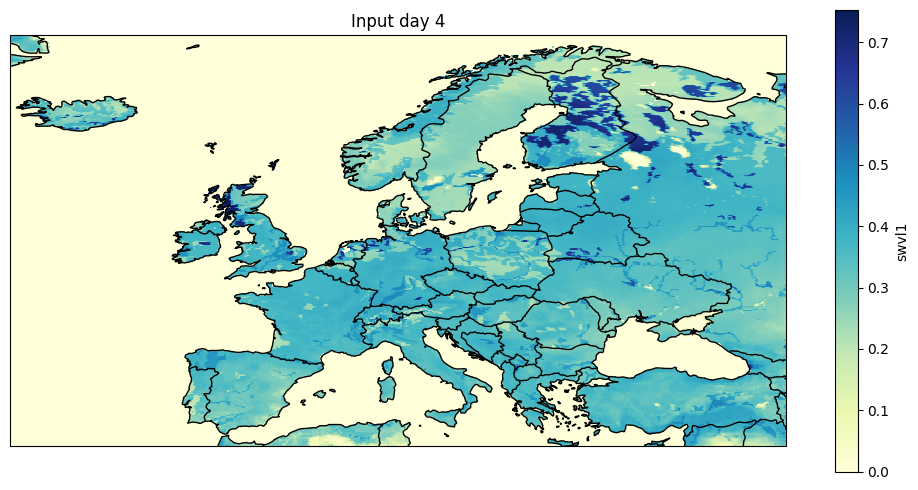

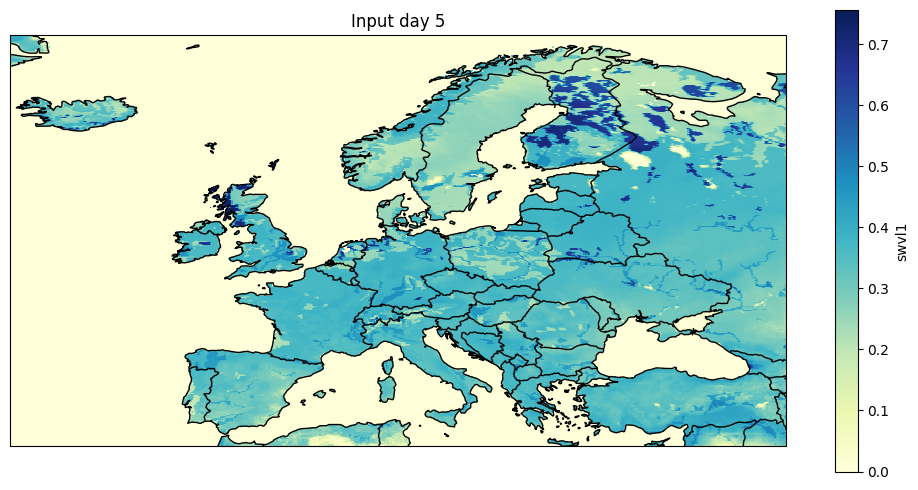

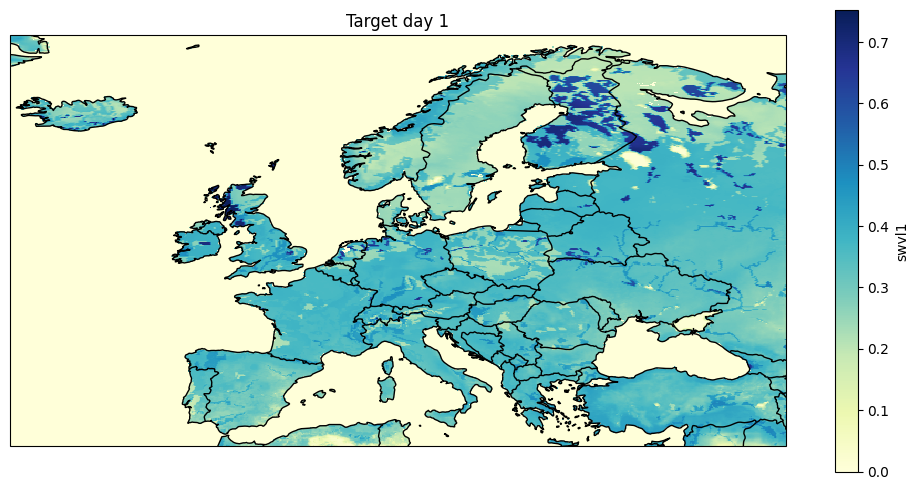

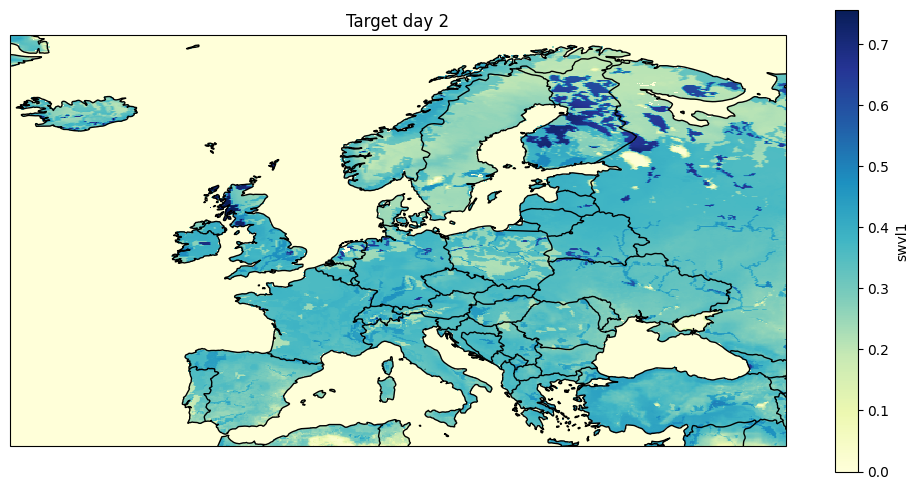

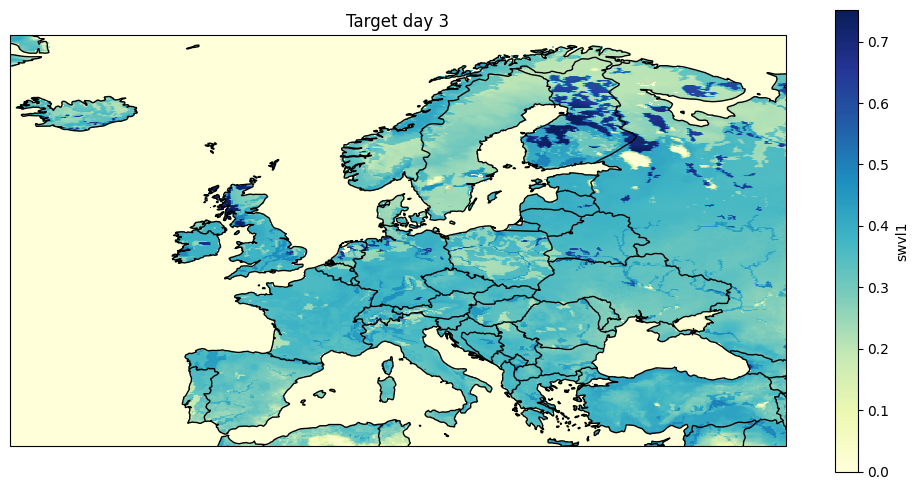

In [56]:
# --- STEP 5: DATASET & DATALOADER ---
class SoilDataset(Dataset):
    def __init__(self, data, input_days, pred_days):
        self.data = data
        self.input_days = input_days
        self.pred_days = pred_days
        self.length = data.shape[0] - input_days - pred_days + 1
        print(f"Available samples: {self.length}")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_days]  # (input_days, C, H, W)
        y = self.data[idx + self.input_days:idx + self.input_days + self.pred_days, 0:1]  # only swvl1
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = SoilDataset(tensor_data, config["input_days"], config["predict_days"])

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f"Dataset split: train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")

train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)

# ---------------- visualizati ----------------
x_sample, y_sample = dataset[0]
print(f"Sample x shape: {x_sample.shape}, y shape: {y_sample.shape}")
plot_tensor_sample(x_sample.numpy(), y_sample.numpy(), lat, lon)

In [58]:
# --- STEP 6: MODEL DEFINITION ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim)
        self.out = nn.Conv2d(hidden_dim, 1, 1)

    def forward(self, x_seq):
        b, t, c, h, w = x_seq.size()
        h_t = torch.zeros((b, 32, h, w), device=x_seq.device)
        c_t = torch.zeros((b, 32, h, w), device=x_seq.device)

        for t_step in range(t):
            h_t, c_t = self.cell(x_seq[:, t_step], h_t, c_t)

        out = self.out(h_t)
        return out.unsqueeze(1).repeat(1, config["predict_days"], 1, 1, 1)

In [59]:
# --- STEP 7: TRAINING LOOP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim=len(config["use_channels"])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(config["epochs"]):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss / len(train_loader):.4f}")

[Epoch 1] Loss: 0.0131
[Epoch 2] Loss: 0.0025
[Epoch 3] Loss: 0.0019
[Epoch 4] Loss: 0.0018
[Epoch 5] Loss: 0.0017
[Epoch 6] Loss: 0.0015
[Epoch 7] Loss: 0.0014
[Epoch 8] Loss: 0.0013
[Epoch 9] Loss: 0.0011
[Epoch 10] Loss: 0.0010


In [60]:
print(model)


ConvLSTM(
  (cell): ConvLSTMCell(
    (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [64]:
# --- Save and Load Model ---
# 保存模型参数
def save_model(model, path="soil_conv_lstm.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# 加载模型参数
def load_model(model, path="soil_conv_lstm.pth", device='cpu'):
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model loaded from {path}")
    return model

save_model(model)
# model = load_model(model, device=device)

Model saved to soil_conv_lstm.pth


Model loaded from soil_conv_lstm.pth


<Figure size 600x600 with 0 Axes>

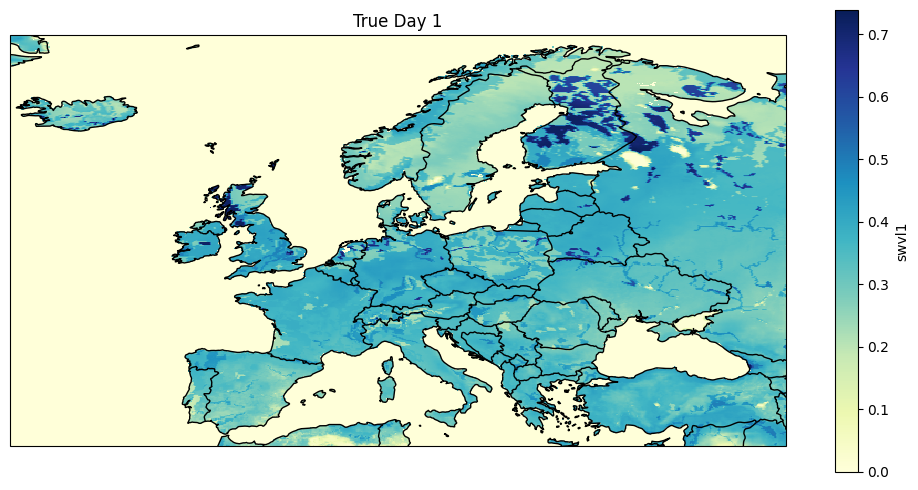

<Figure size 600x600 with 0 Axes>

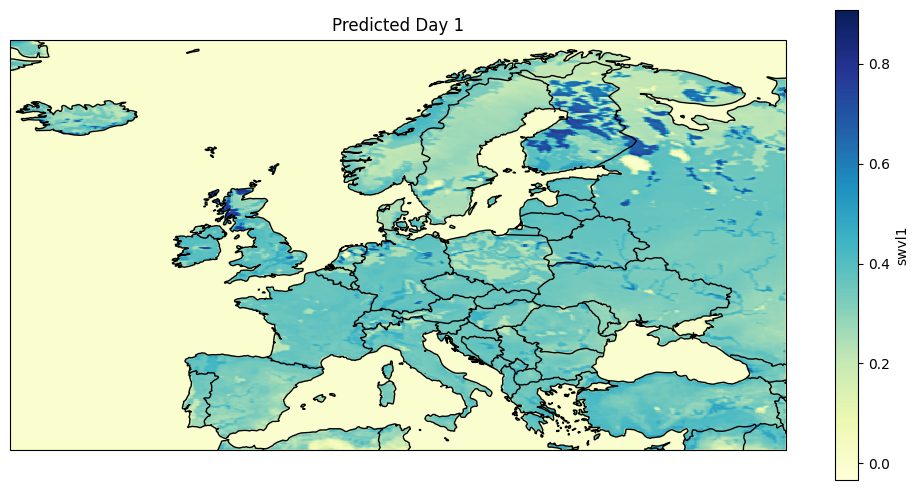

<Figure size 600x600 with 0 Axes>

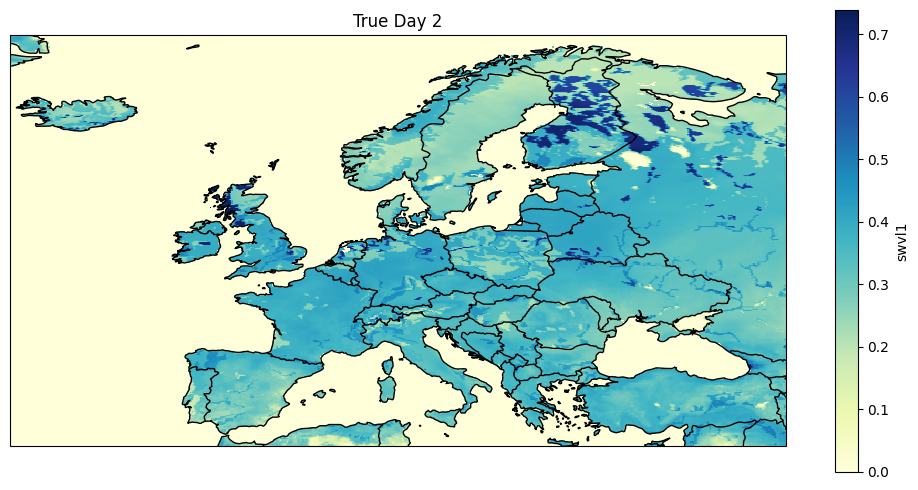

<Figure size 600x600 with 0 Axes>

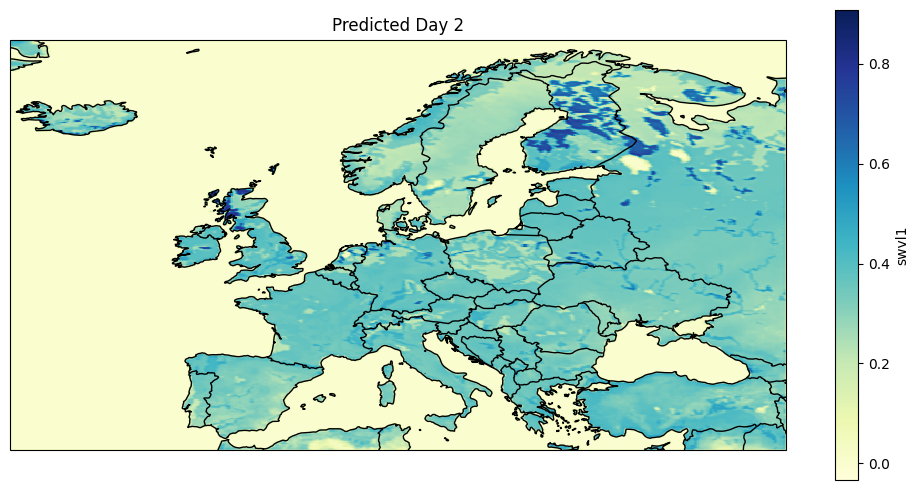

<Figure size 600x600 with 0 Axes>

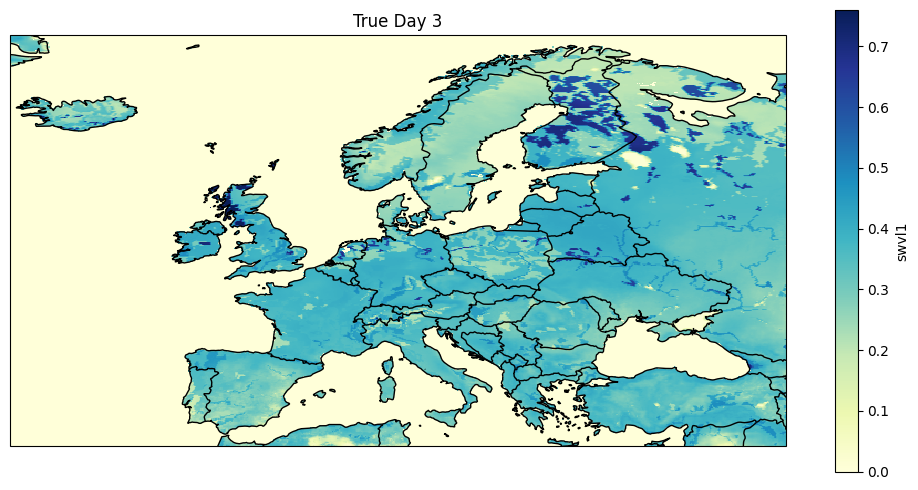

<Figure size 600x600 with 0 Axes>

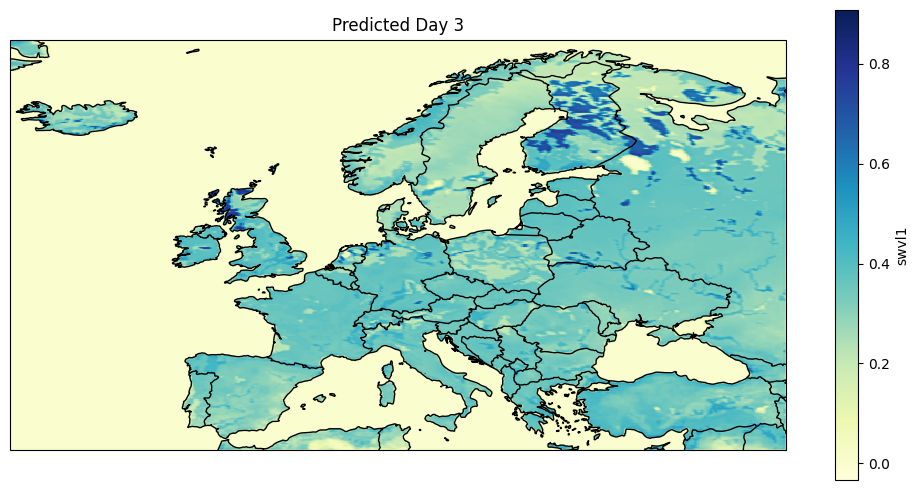

RMSE: 0.0266
MSE: 0.0007
MAE: 0.0123
R2: 0.9787


In [74]:
# --- STEP 8: EVALUATION ---
def predict_and_visualize(model, dataset, lat, lon, device='cpu', sample_idx=0):
    model.eval()
    x, y_true = dataset[sample_idx]
    x = x.unsqueeze(0).to(device)  # (1, input_days, C, H, W)
    with torch.no_grad():
        y_pred = model(x)  # (1, pred_days, 1, H, W)
    y_pred = y_pred.squeeze(0).cpu().numpy()    # (pred_days, 1, H, W)
    y_true = y_true.numpy()                     # (pred_days, 1, H, W)

    # 可视化每一天的预测和真实
    for t in range(y_pred.shape[0]):
        plt.figure(figsize=(6, 6))
        plot_variable_day(np.transpose(y_true[t], (1,2,0)), lat, lon, 0, 0, f"True Day {t+1}")
        plt.show()
        plt.figure(figsize=(6, 6))
        plot_variable_day(np.transpose(y_pred[t], (1,2,0)), lat, lon, 0, 0, f"Predicted Day {t+1}")
        plt.show()
    return y_true, y_pred

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    # 输入: (pred_days, 1, H, W)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    return {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}


# 加载模型（推理时建议重新加载，防止训练态）
model_eval = load_model(model, "soil_conv_lstm.pth", device=device)
model_eval.eval()

# 选一个测试样本预测并可视化
sample_idx = 0  # 你可以换成其它test_set中的样本
y_true, y_pred = predict_and_visualize(model_eval, test_set, lat, lon, device=device, sample_idx=sample_idx)

# 计算指标
metrics = compute_metrics(y_true, y_pred)


16